In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import shutil
import itertools
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [6]:
# Directory paths
train_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\training_set"
test_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\test_set"
valid_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\validation_set"
new_test_dir = r"C:\\Users\\wrksy\\OneDrive\\Desktop\\Projects\\7088CEM\\Image_classification\\data\\new_test_set"

In [7]:

# Function to count images in folders
def count_images_in_folders(directory):
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            print(f"Folder: {folder}, Images Count: {images_count}")

print("Train Set:")
count_images_in_folders(train_dir)

print("\nTest Set:")
count_images_in_folders(test_dir)

Train Set:
Folder: cats, Images Count: 4001
Folder: dogs, Images Count: 4006

Test Set:
Folder: cats, Images Count: 1012
Folder: dogs, Images Count: 1013


In [9]:
# Create validation directory if not exists
os.makedirs(valid_dir, exist_ok=True)

# Function to copy files
def copy_files(src_dir, dst_dir, category, num_files):
    os.makedirs(os.path.join(dst_dir, category), exist_ok=True)
    files = os.listdir(os.path.join(src_dir, category))
    num_files_to_copy = min(num_files, len(files))
    files_to_copy = files[:num_files_to_copy]
    for file in files_to_copy:
        src_path = os.path.join(src_dir, category, file)
        dst_path = os.path.join(dst_dir, category, file)
        shutil.copy(src_path, dst_path)
        
# Copy 500 cats and 500 dogs from test set to validation set
copy_files(test_dir, valid_dir, 'cats', 500)
copy_files(test_dir, valid_dir, 'dogs', 500)

print("Validation Set:")
count_images_in_folders(valid_dir)

Validation Set:
Folder: cats, Images Count: 500
Folder: dogs, Images Count: 500


In [10]:
# Function to count images and return as dictionary
def count_images_in_folders(directory):
    folder_counts = {}
    folders = os.listdir(directory)
    for folder in folders:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images_count = len(os.listdir(folder_path))
            folder_counts[folder] = images_count
    return folder_counts

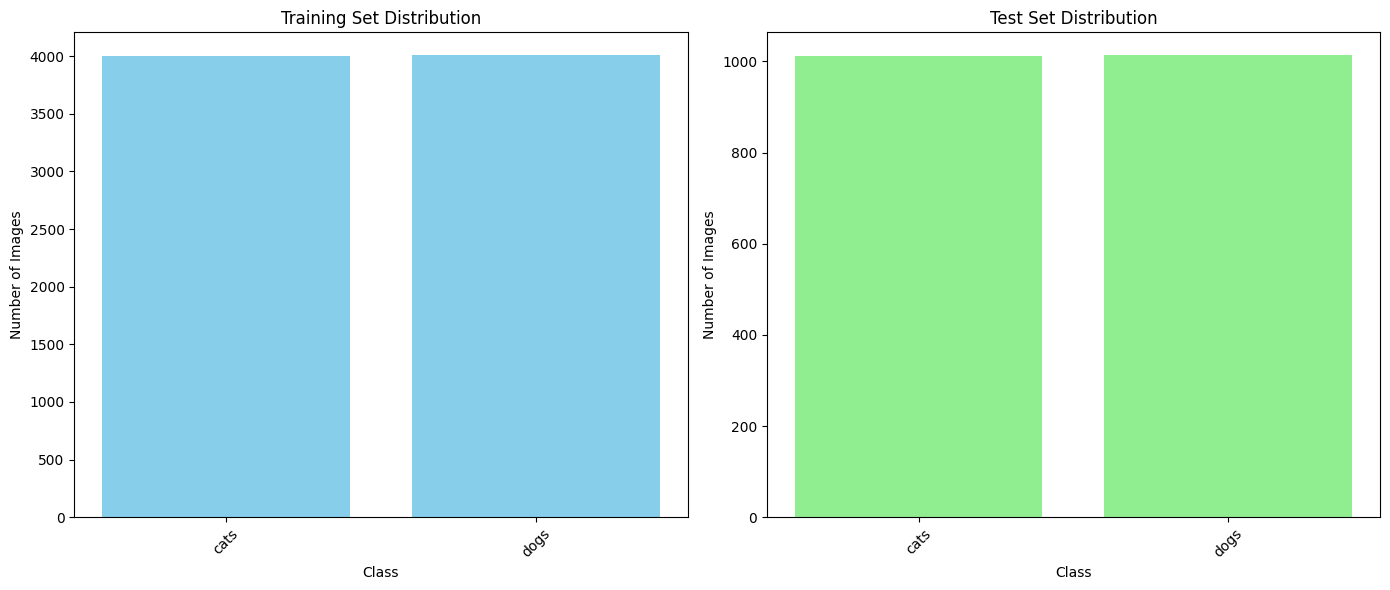

In [11]:
# Plotting the distribution
def plot_distribution(train_counts, test_counts):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # Training set distribution
    axes[0].bar(train_counts.keys(), train_counts.values(), color='skyblue')
    axes[0].set_title('Training Set Distribution')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Images')
    axes[0].tick_params(axis='x', rotation=45)

    # Test set distribution
    axes[1].bar(test_counts.keys(), test_counts.values(), color='lightgreen')
    axes[1].set_title('Test Set Distribution')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Number of Images')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

train_counts = count_images_in_folders(train_dir)
test_counts = count_images_in_folders(test_dir)
plot_distribution(train_counts, test_counts)

In [12]:
# Data Preparation
image_size = (224, 224)
batch_size = 32

# ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# No data augmentation for validation and test sets
valid_test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)


In [13]:
# Create batches
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

valid_batches = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_batches = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8005 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [14]:
# Sanity check for data consistency
assert train_batches.samples == 8005, f"Expected 8005 samples in train_batches, but got {train_batches.samples}"
assert test_batches.samples == 2023, f"Expected 2023 samples in test_batches, but got {test_batches.samples}"
assert valid_batches.samples == 1000, f"Expected 1000 samples in valid_batches, but got {valid_batches.samples}"
assert train_batches.num_classes == test_batches.num_classes == valid_batches.num_classes == 2, \
    f"Expected 2 classes in all batches, but got {train_batches.num_classes}, {test_batches.num_classes}, {valid_batches.num_classes}"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-83.465675..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-110.99924..139.26358].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-106.866455..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-104.849495..150.94052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..145.91928].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.05078].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-98.387375..151.0

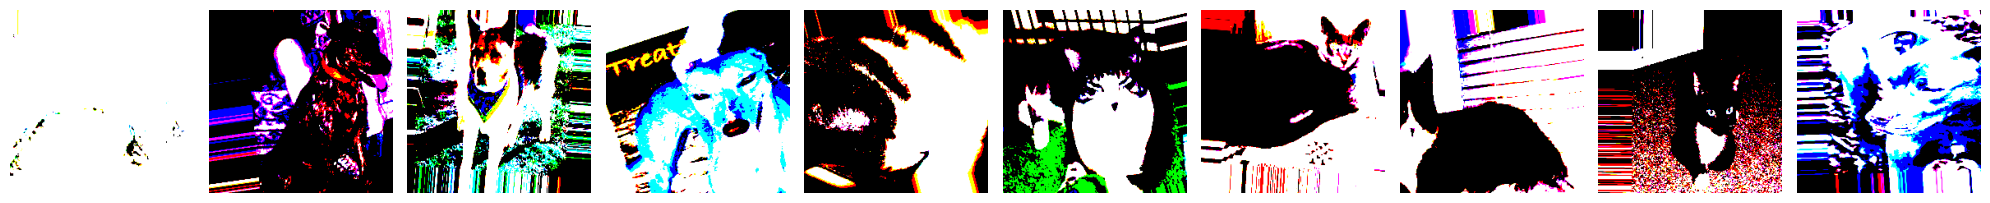

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [15]:
# Function to plot images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some training images
imgs, labels = next(train_batches)
plotImages(imgs)
print(labels)

In [16]:
# Build and Train a Simple CNN
simple_cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])


C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# Compile the simple CNN model
simple_cnn_model.compile(optimizer=Adam(learning_rate=0.0001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Train the simple CNN model
simple_cnn_model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=10,
    verbose=2
)

Epoch 1/10


C:\Users\wrksy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 - 221s - 881ms/step - accuracy: 0.5775 - loss: 4.8166 - val_accuracy: 0.6350 - val_loss: 1.7984
Epoch 2/10
251/251 - 160s - 639ms/step - accuracy: 0.6191 - loss: 1.0830 - val_accuracy: 0.6340 - val_loss: 0.8357
Epoch 3/10
251/251 - 162s - 644ms/step - accuracy: 0.6255 - loss: 0.7492 - val_accuracy: 0.6760 - val_loss: 0.6534
Epoch 4/10
251/251 - 160s - 639ms/step - accuracy: 0.6547 - loss: 0.6517 - val_accuracy: 0.6850 - val_loss: 0.5962
Epoch 5/10
251/251 - 160s - 639ms/step - accuracy: 0.6616 - loss: 0.6278 - val_accuracy: 0.6960 - val_loss: 0.5753
Epoch 6/10
251/251 - 201s - 801ms/step - accuracy: 0.6783 - loss: 0.6034 - val_accuracy: 0.7100 - val_loss: 0.5726
Epoch 7/10
251/251 - 217s - 865ms/step - accuracy: 0.6943 - loss: 0.5841 - val_accuracy: 0.7200 - val_loss: 0.5535
Epoch 8/10
251/251 - 209s - 834ms/step - accuracy: 0.6956 - loss: 0.5868 - val_accuracy: 0.7290 - val_loss: 0.5469
Epoch 9/10
251/251 - 176s - 702ms/step - accuracy: 0.7054 - loss: 0.5704 - val_accuracy: 0.

In [18]:
# Model Prediction and Confusion Matrix
predictions = simple_cnn_model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_color='black'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=text_color)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
              precision    recall  f1-score   support

        cats       0.74      0.73      0.73      1011
        dogs       0.73      0.74      0.74      1012

    accuracy                           0.74      2023
   macro avg       0.74      0.74      0.74      2023
weighted avg       0.74      0.74      0.74      2023



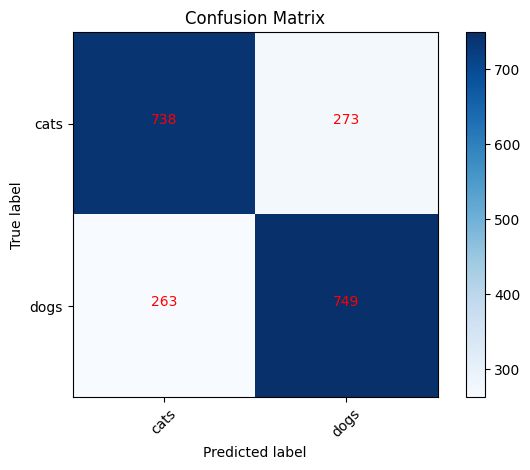

In [19]:
# Plot confusion matrix
cm_plot_labels = ['cats', 'dogs']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix', text_color='red')

# Print classification report
print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))


In [20]:
# Download VGG16 model without the top classification layer
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=(224,224,3))

# Create new model and add layers from VGG16
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

# Freeze the layers
for layer in model.layers:
    layer.trainable = False

# Add custom output layers
model.add(Flatten())
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [22]:
# Learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=10,
    verbose=2,
    callbacks=[reduce_lr]
)

Epoch 1/10
251/251 - 1785s - 7s/step - accuracy: 0.9074 - loss: 1.1272 - val_accuracy: 0.9640 - val_loss: 0.6567 - learning_rate: 1.0000e-04
Epoch 2/10
251/251 - 1706s - 7s/step - accuracy: 0.9552 - loss: 0.4972 - val_accuracy: 0.9700 - val_loss: 0.5898 - learning_rate: 1.0000e-04
Epoch 3/10
251/251 - 1818s - 7s/step - accuracy: 0.9639 - loss: 0.4221 - val_accuracy: 0.9760 - val_loss: 0.5438 - learning_rate: 1.0000e-04
Epoch 4/10
251/251 - 1806s - 7s/step - accuracy: 0.9694 - loss: 0.3521 - val_accuracy: 0.9810 - val_loss: 0.5521 - learning_rate: 1.0000e-04
Epoch 5/10
251/251 - 1801s - 7s/step - accuracy: 0.9701 - loss: 0.3459 - val_accuracy: 0.9810 - val_loss: 0.5713 - learning_rate: 1.0000e-04
Epoch 6/10
251/251 - 1804s - 7s/step - accuracy: 0.9723 - loss: 0.3227 - val_accuracy: 0.9820 - val_loss: 0.5722 - learning_rate: 1.0000e-04
Epoch 7/10
251/251 - 1816s - 7s/step - accuracy: 0.9750 - loss: 0.2810 - val_accuracy: 0.9810 - val_loss: 0.5557 - learning_rate: 1.0000e-04
Epoch 8/10
25

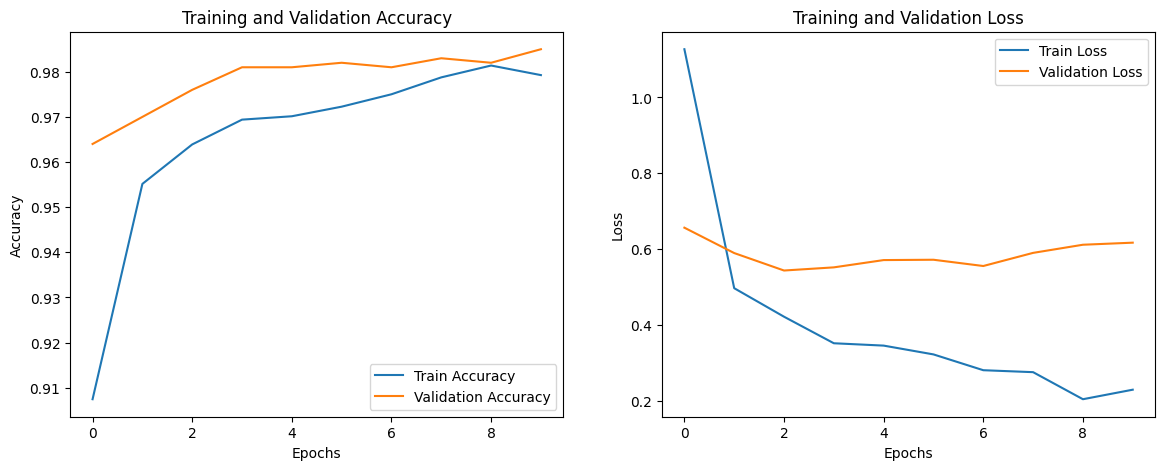

Confusion matrix, without normalization


              precision    recall  f1-score   support

        cats       0.99      0.98      0.98      1011
        dogs       0.98      0.99      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



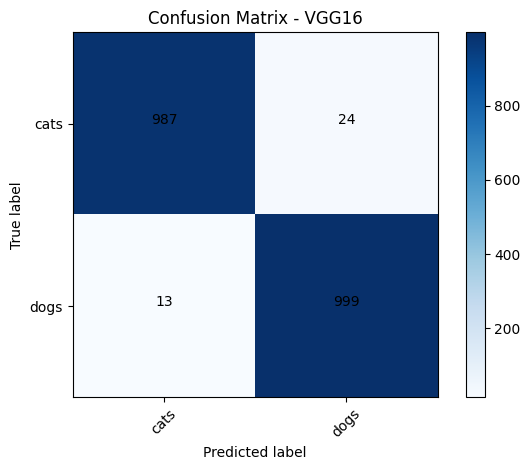

In [23]:
# Plot training and validation accuracy and loss
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    # Plot loss
    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Training and Validation Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.show()

plot_training_history(history)

# Predict and evaluate on test set
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

# Plot confusion matrix for VGG16 model
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix - VGG16')

# Print classification report for VGG16 model
print(classification_report(test_batches.classes, np.argmax(predictions, axis=-1), target_names=cm_plot_labels))

# Save the trained model
model.save('fine_tuned_vgg16_model.h5')